### **Google Drive Connection**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### **Un ZIP data**
Make sure to create a newfolder in your gdrive under the name "NLP", then add the data as compressed file with .zip extension

In [ ]:
!unzip /content/gdrive/MyDrive/NLP/dataset.zip > /dev/nullAN



# **Step 1: Reading & Exploring Data**

In [61]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from numpy import positive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC



nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
data_path = '/content/dataset'

positive_reviews = []
negative_reviews = []

for data_class in os.listdir(data_path):
  for review in os.listdir(os.path.join(data_path, data_class)):
    with open(os.path.join(data_path, data_class, review)) as f:
      review_content = f.read().replace('\n', '')

      if data_class == 'pos':
        positive_reviews.append(review_content)
      else:
        negative_reviews.append(review_content)

**Review Sample**

In [ ]:
print('Positive Review Sample')
print(positive_reviews[0])
print()
print('Negative Review Sample')
print(negative_reviews[15])

Positive Review Sample
countries and legal systems that take the rule of law principle seriously , had forbidden judges and juries to make judgements in all matters that could involve them personally . luckily , movie reviewers aren't burdened with such legislation . otherwise , small pool of very special movies would be forever ignored by this reviewer . in case of star wars , 1977 science fiction epic by george lucas , the consequences would be even more severe , because that film is very special for tens of millions , if not hundreds of millions of fans . in any case , objectivity is something seldom seen in star wars reviews , because undisputed majority of reviewers rate it as one of the best , if not the best film of all times . those who don't usually have some difficulties in hiding their artistic snobbery . the author of this review must also concede his inability to use cold , objective standards in reviewing this film . like so many previous reviewers , i must note that i wa

**Data Distribution**

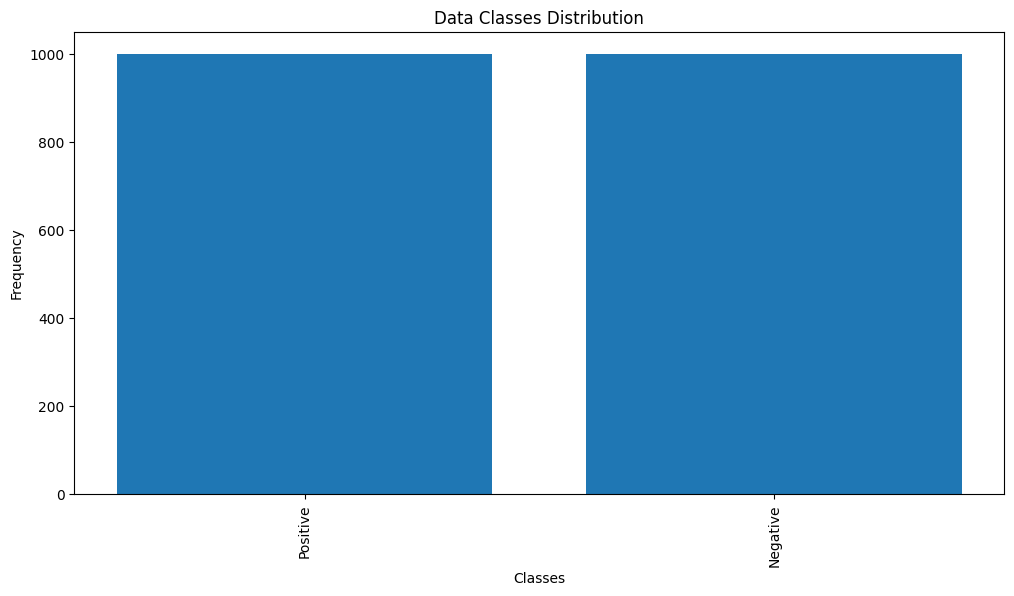

In [ ]:
class_labels = ['Positive', 'Negative']
frequency = [len(positive_reviews), len(negative_reviews)]

fig = plt.figure(figsize=(12, 6))
plt.bar(class_labels, frequency)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.title('Data Classes Distribution')
plt.show()

**Reviews Words Count Distribution**

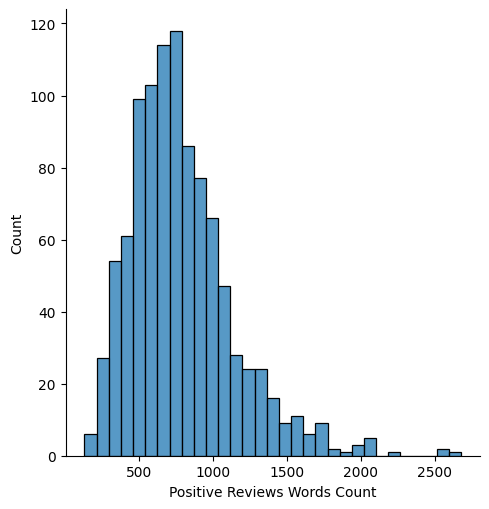

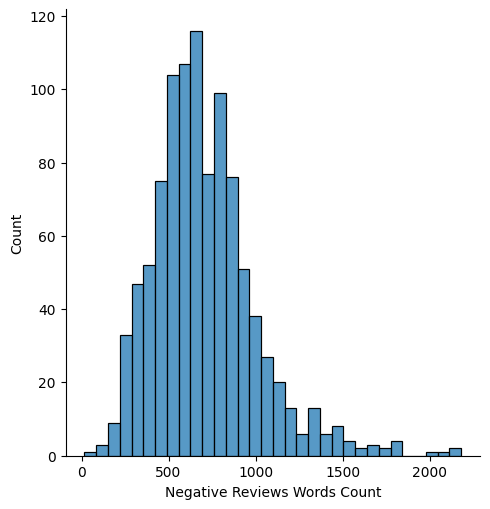

<Figure size 1600x800 with 0 Axes>

In [ ]:
positive_reviews_words_count = []
negative_reviews_words_count = []


for i in range(len(positive_reviews)):
  positive_reviews_words_count.append(len(positive_reviews[i].split()))
  negative_reviews_words_count.append(len(negative_reviews[i].split()))


sns.displot(positive_reviews_words_count)
plt.xlabel("Positive Reviews Words Count")
sns.displot(negative_reviews_words_count)
plt.xlabel("Negative Reviews Words Count")


sns.set_style("darkgrid")
plt.figure(figsize=(16, 8))
plt.show()

# **Step 2: Preprocessing**

In [ ]:
def tokenize_reviews(reviews):
  tokens = []
  for review in reviews:
   tokens.append(word_tokenize(review))
  return tokens

In [ ]:
def remove_stop_words(Reviews_tokens):
  tokens = []
  stop_words = set(stopwords.words('english'))
  for token in Reviews_tokens:
    if token not in stop_words:
      tokens.append(token)
  return tokens

In [ ]:
def lematize_tokens(Reviews_tokens):
  tokens = []
  lemmatizer = WordNetLemmatizer()
  for token in Reviews_tokens:
      tokens.append(lemmatizer.lemmatize(token))
  return tokens

In [ ]:
def construct_review_sring_from_tokens(tokens):
  return ' '.join(tokens)

In [ ]:
def preProcess_Reviews(reviews):
  reviews = [re.sub(r"(?![\s])\W+", "", review) for review in reviews]
  reviews = tokenize_reviews(reviews)
  reviews = [lematize_tokens(review) for review in reviews]
  reviews = [remove_stop_words(review) for review in reviews]
  reviews = [construct_review_sring_from_tokens(review) for review in reviews]
  return reviews

In [ ]:
positive_reviews = preProcess_Reviews(positive_reviews)
negative_reviews = preProcess_Reviews(negative_reviews)

# **Step 3: Data Preparation** (make data frame)

In [ ]:
Movies_reviews = positive_reviews + negative_reviews
reviews_classes = np.append(np.ones(1000, dtype=int), np.zeros(1000, dtype=int))

print(len(Movies_reviews))
print(len(reviews_classes))

data = {'reviews': Movies_reviews, 'sentiment': reviews_classes} # 1 for positive, 0 for negative
df = pd.DataFrame(data)
print(df)

2000
2000
                                                reviews  sentiment
0     country legal system take rule law principle s...          1
1     calendar year ha even reached midway point has...          1
2     guess credit jackie chan general likeability f...          1
3     national lampoon animal house made 1978 set 19...          1
4     year 1962 military conducting nuclear testing ...          1
...                                                 ...        ...
1995  beware movie director name title take john car...          0
1996  synopsis blond criminal psychologist sarah cho...          0
1997  plunkett macleane period piece mired modern mt...          0
1998  one contributor destruction batman film franch...          0
1999  tagline film house born bad didnt expect much ...          0

[2000 rows x 2 columns]


# **Step 4: Feature Extraction**

splitting data (70% train, 30% test)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data['reviews'], data['sentiment'], test_size=0.3, shuffle=True)
X_train[0]

'always bad sign core audience film child either walking early halfasleep credit roll end film sum dreadful ugliness 102 dalmatian cold pea soup cute animal stupid home alone antic boring puppy love subplot dumb human glenn close reprising best joan crawford impression indeed walt disney rolling grave cursing john hughesname making original liveaction 101 dalmatian one worst kiddie flick time sequel main culprit behind hideousness 102 dalmatian predecessor 101 dalmatian original made 100 million dollar box office spawned torrid collection collectible item ended month later discount bin walmarts across country generally made every kid planet want damn dalmatian pup christmas well four year since dalmatian fever coming back time digitally enhanced story cruella de vil glenn close released prison due cure puppy homicide urge one dr pavlov oh witty rejoins world dog lover assigned probation officer oddly turn victim original film cruella becomes ella dog lover plot twist like dog leash cau

Method 1 : TF-IDF

In [ ]:
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_train_tf = tf_idf.transform(X_train)
print("n_samples: %d, n_features: %d" % X_train_tf.shape)


n_samples: 1400, n_features: 37046


In [ ]:
X_test_tf = tf_idf.transform(X_test)
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 600, n_features: 37046


# **Step 5: Modeling**

**Model 1 : Naive Bayes Classifier**

In [ ]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, Y_train)

y_pred = naive_bayes_classifier.predict(X_test_tf)

              precision    recall  f1-score   support

    Positive       0.88      0.76      0.82       309
    Negative       0.78      0.89      0.83       291

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600

Navie Bayes Classifer Accuracy:  0.8266666666666667


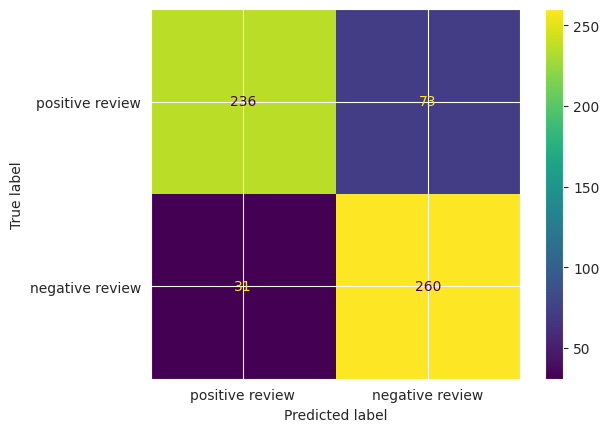

In [51]:
class_report = metrics.classification_report(Y_test, y_pred, target_names=['Positive', 'Negative'])
print(class_report)

matrix = confusion_matrix(Y_test,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['positive review','negative review'])

disp.plot()

acc = metrics.accuracy_score(Y_test,y_pred)
print("Navie Bayes Classifer Accuracy: ", acc)

**Model 2 : Logistic Regression Classifier**

In [57]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train_tf, Y_train)

y_pred2 = logistic_classifier.predict(X_test_tf)

              precision    recall  f1-score   support

    Positive       0.85      0.81      0.83       309
    Negative       0.81      0.85      0.83       291

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600

Navie Bayes Classifer Accuracy:  0.8283333333333334


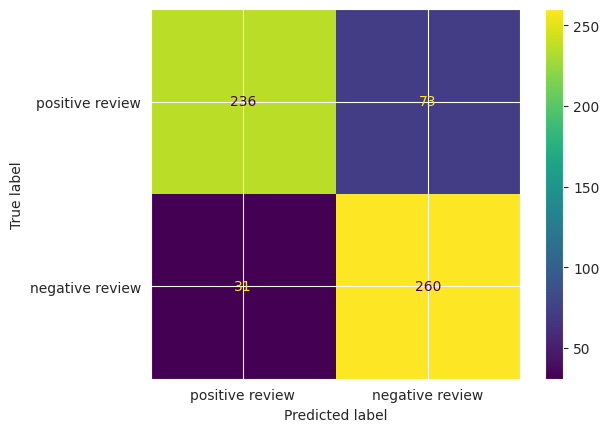

In [60]:
class_report2 = metrics.classification_report(Y_test, y_pred2, target_names=['Positive', 'Negative'])
print(class_report2)

matrix2 = confusion_matrix(Y_test,y_pred2)

disp2 = ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['positive review','negative review'])

disp2.plot()

acc2 = metrics.accuracy_score(Y_test,y_pred2)
print("Navie Bayes Classifer Accuracy: ", acc2)

**Model 3 : SVM**

In [63]:
svm_classifer = SVC()
svm_classifer.fit(X_train_tf, Y_train)

y_pred3 = logistic_classifier.predict(X_test_tf)

              precision    recall  f1-score   support

    Positive       0.85      0.81      0.83       309
    Negative       0.81      0.85      0.83       291

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600

Navie Bayes Classifer Accuracy:  0.8283333333333334


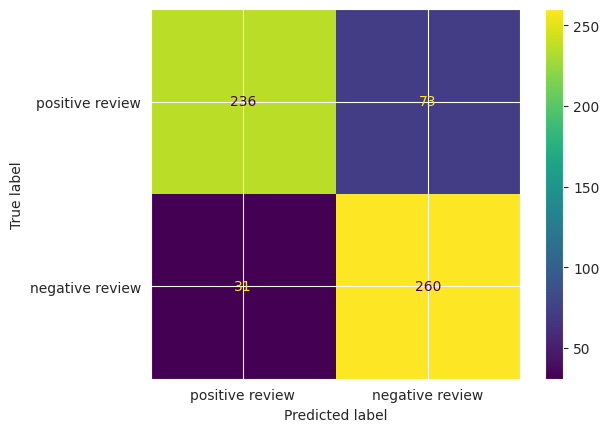

In [64]:
class_report3 = metrics.classification_report(Y_test, y_pred3, target_names=['Positive', 'Negative'])
print(class_report3)

matrix2 = confusion_matrix(Y_test,y_pred3)

disp3 = ConfusionMatrixDisplay(confusion_matrix=matrix,
                               display_labels=['positive review','negative review'])

disp3.plot()

acc3 = metrics.accuracy_score(Y_test,y_pred3)
print("Navie Bayes Classifer Accuracy: ", acc3)

**Accuracy Summary**

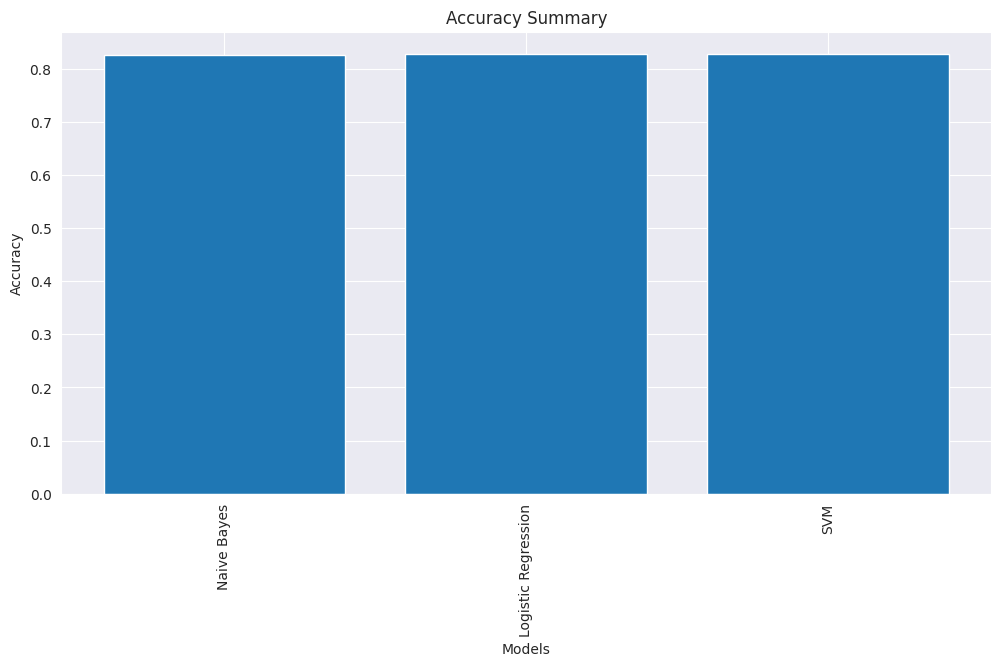

In [68]:
models = ['Naive Bayes', 'Logistic Regression', 'SVM']
accuracies = [acc, acc2, acc3]

fig = plt.figure(figsize=(12, 6))
plt.bar(models, accuracies)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation = 90)
plt.title('Accuracy Summary')
plt.show()